<a href="https://colab.research.google.com/github/zi-onion/24-2-ESAA/blob/main/10_18_%EC%BB%A8%ED%85%90%EC%B8%A0_%EA%B8%B0%EB%B0%98_%ED%95%84%ED%84%B0%EB%A7%81_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

파이썬 머신러닝 완벽가이드 개정2판 ch9 p.601-613

## 05 컨텐츠 기반 필터링 실습 - TMDB 5000 영화 데이터 세트


### **장르 속성을 이용한 영화 콘텐츠 기반 필터링**

콘텐츠 기반 필터링: 사용자가 선호한 영화에 대해 그 영화와 비슷한 특성/속성, 구성 요소 등을 가진 다른 영화를 추천하는 것

-> 영화 장르 속성을 기반으로 하는 콘텐츠 기반 필터링 추천 시스템





### **데이터 로딩 및 가공**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies =pd.read_csv('/content/drive/MyDrive/2024/ESAA/Data/tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


-> 4803개의 레코드와 20개의 피처로 구성

필요한 피쳐 추출

:id, 영화제목, 영화가 속한 여러 가지 장르, 평균 평점 , 평점 투표수, 영화의 인기, 영화 주 키워드, 영화 개요설명

In [3]:
movies_df = movies[['id','title', 'genres', 'vote_average', 'vote_count',
                 'popularity', 'keywords', 'overview']]

리스트 내부에 딕셔너리가 여러 개 있는 형태는 DataFrame으로 만들 때 가공이 필요함.

In [4]:
# 칼럼의 형태 확인
pd.set_option('max_colwidth', 100)
movies_df[['genres','keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


->  genres 칼럼의 문자열을 분해해서 개별 장르를 파이썬 리스트 객체로 추출해야 함.

In [5]:
from ast import literal_eval

movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

In [6]:
movies_df['genres'] = movies_df['genres'].apply(lambda x : [ y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : [ y['name'] for y in x])
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


-> **apply(lambda x : [y['name']
for y in x])**: 리스트 내 여러 개의 딕셔너리의 'name' 키에 해당하는 값을 찾아 이를
리스트 객체로 변환

### **장르 콘텐츠 유사도 측정**
-> 가장 간단한 방법하게 genres를 문자열로 변경한 뒤 이를 CountVectorizer로 피처 벡터화한 행렬 데이터 값을 코사인 유사도로 비교

**[구현 단계]**
1. 문자열로 변환된 genres 칼럼을 Count 기반으로 피처 벡터화 변환합니다.

In [9]:
from operator import ge
from sklearn.feature_extraction.text import CountVectorizer

# Countvectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x : (' ').join(x))
count_vect = CountVectorizer(min_df=1, ngram_range=(1,2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


-> **('구분문자,).join(리스트 객체)**: 리스트 객체 내의 개별 값을 연속된 문자열로 변환

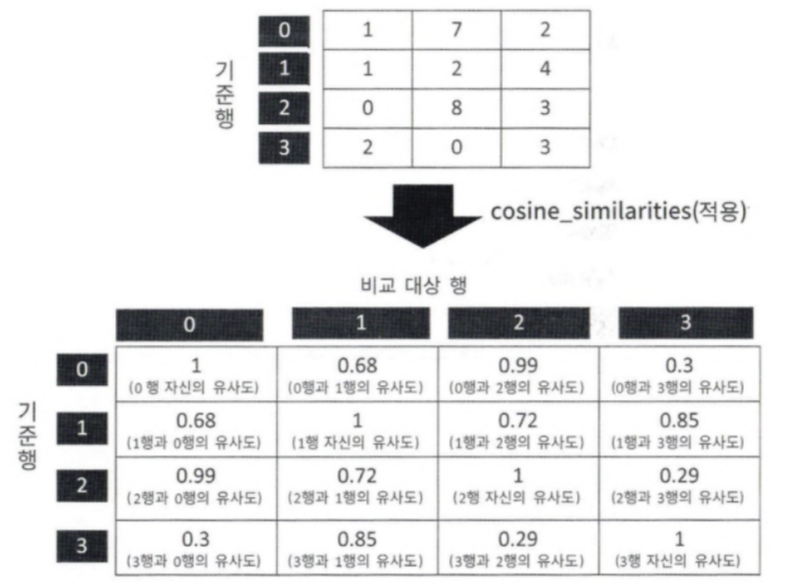


2. genres 문자열을 피처 벡터화 행렬로 변환한 데이터 세트를 코사인 유사도를 통해 비교합니다. 이를 위해 데이터 세트의 레코드별로 타 레코드와 장르에서 코사인 유사도 값을 가지는 객체를 생성합니다

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)

# 앞 2개 데이터 추출
print(genre_sim[:2])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]
 [0.59628479 1.         0.4        ... 0.         0.         0.        ]]


->
cosine_similarity()로 생성된 genre_sim 객체는 movies_df의 genrejiteral 칼럼을 피처 벡
터화한 행렬(genre mat) 데이터의 행（레코드）별 유사도 정보를 가짐



3. 쟝르 유사도가 높은 영화 중에 평점이 높은 순으로 영화를 추천합니다.

In [11]:
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])

[[   0 3494  813 ... 3038 3037 2401]]


-> **argsort()[:,::-1]**: 유사도가 높은 순으로 정리된 genre_sim 객체의 비교 행 위치
인덱스 값 추출

### **장르 콘텐츠 필터링을 이용한 영화 추천**

In [12]:
# 장르 유사도에 따라 영화를 추천하는 함수

def find_sim_movie(df, sorted_ind, title_name, top_n=10):

    # 인자로 입력된 movies_df DataFrame에서 'title' 컬럼이 입력된 title_name 값인 DataFrame추출
    title_movie = df[df['title'] == title_name]

    # title_named을 가진 DataFrame의 index 객체를 ndarray로 반환하고
    # sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n 개의 index 추출
    title_index = title_movie.index.values
    similar_indexes = sorted_ind[title_index, :(top_n)]

    # 추출된 top_n index들 출력. top_n index는 2차원 데이터 임.
    #dataframe에서 index로 사용하기 위해서 1차원 array로 변경
    print(similar_indexes)
    similar_indexes = similar_indexes.reshape(-1)

    return df.iloc[similar_indexes]

In [13]:
# 영화 '대부'와 장르별로 유사한 영화 10개 추천

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather',10)
similar_movies[['title', 'vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


-> 고객에게 추천하기에 낯선 영화들/평점이 낮은 영화들이 존재, 개선 필요

In [14]:
# vote_average 상위 10개 영화

movies_df[['title','vote_average','vote_count']].sort_values('vote_average', ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


유명한 영화 평점 사이트인 IMDB에서는 평가 횟수에 대한 가중치가 부여된 평점(Weighted Rating)
방식을 사용

**가중평점(Weight Rating)**
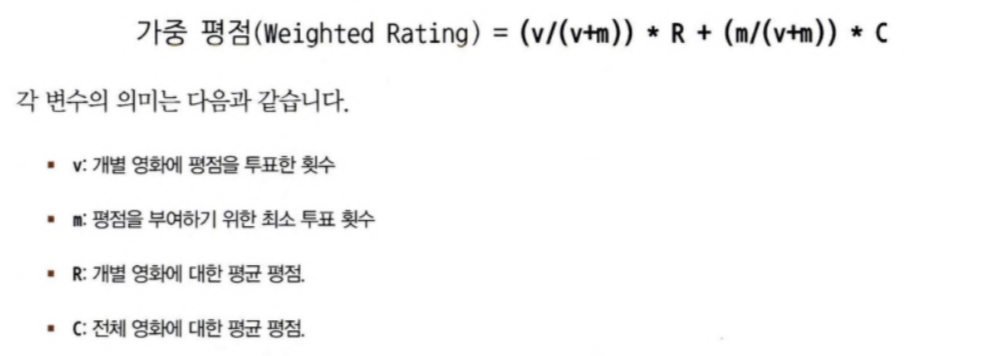

In [15]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)
print('C:',round(C,3), 'm:',round(m,3))

C: 6.092 m: 370.2


기존 평점을 새로운 가중 평점으로 변경하는 함수를 통해 새로운 평점 정보 'vote_weighted' 값 생성.

In [16]:
percentile = 0.6
m = movies_df['vote_count'].quantile(percentile)
C = movies_df['vote_average'].mean()

def weighted_vote_average(record):
    v = record['vote_count']
    R = record['vote_average']

    return ( (v/(v+m)) * R ) + ( (m/(m+v)) * C )

movies_df['weighted_vote'] = movies_df.apply(weighted_vote_average, axis=1)

In [17]:
# weighted_vote 평점 상위 10개 영화

movies_df[['title','vote_average','weighted_vote','vote_count']].sort_values('weighted_vote',
                                                                          ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


-> 매우 유명한 영화들이 잘 추출됨.

가중 평점을 적용한 평점 기준에 따라 영화 추천

In [18]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    title_movie = df[df['title'] == title_name]
    title_index = title_movie.index.values

    # top_n의 2배에 해당하는 쟝르 유사성이 높은 index 추출
    similar_indexes = sorted_ind[title_index, :(top_n*2)]
    similar_indexes = similar_indexes.reshape(-1)
# 기준 영화 index는 제외
    similar_indexes = similar_indexes[similar_indexes != title_index]

    # top_n의 2배에 해당하는 후보군에서 weighted_vote 높은 순으로 top_n 만큼 추출
    return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather',10)
similar_movies[['title', 'vote_average', 'weighted_vote']]

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427


-> 이전 추천 영화보다 훨씬 나은 영화들이 추천됨.